#### Common Imports

In [41]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score
from graphviz import Source

path = r'C:\Users\drjos\OneDrive\Desktop\Data Science Notes\Hands On Machine Learning'

# Training and Visualizing a Decision Tree

A quick example using the iris dataset as a toy.

In [19]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

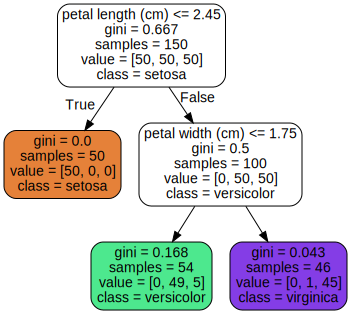

In [20]:
export_graphviz(
        tree_clf, out_file=str(path + r"\iris_tree.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names, rounded=True, filled=True)

Source.from_file(path + r"\iris_tree.dot") 

**Note:** Decision Trees don't require scaling or centering - very little data preparation.

# Classification Decision Trees

### Gini Impurity

A node's **value** attribute indicates how many training instances of each class is in the node. A node's **gini impurity** indicates the probability of misclassifying an observation using that node. A "_pure_" node has $0$ gini impurity.

_Gini Impurity:_ $\hskip 30pt G_i = 1 - \displaystyle\sum_{k=1}^n p_{i,k}^2$ where
- $G_i$ is the Gini impurity of the $i^{th}$ node.
- $p_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node.

In the example above, the **versicolor** leaf has $0.168 \approx 1 - (0/54)^2 - (49/54)^2 - (5/54)^2$

### Estimating Class Probabilities

For a given instance, the probability of a certain classification based on the leaf the instance lands. This is $p_{i,k}$ of the gini impurity.

An example of an iris (not in the training data) with petals that are $5$cm long and $1.5$cm wide:

In [21]:
print(tree_clf.predict_proba([[5,1.5]]).round(3))
print(tree_clf.predict([[5,1.5]]))

[[0.    0.907 0.093]]
[1]


### CART Training Algorithm

The _Classification and Regression Tree_ (CART) algorithm works by splitting the training set into two subsets using a feature $k$ and a threshold $t_k$. The aim is to minimize the CART cost function and split the node into two.

_CART Cost Function for Classification:_ $\hskip 20pt J(k, t_k) = \dfrac{m_{\text{left}}}{m}\,G_{\text{left}} + \dfrac{m_{\text{right}}}{m}\,G_{\text{right}}$ 
- $G_{\text{left/right}}$ measures the gini impurity of the left/right subset.
- $m_{\text{left/right}}$ is the number of instances in the left/right subset.

**Note:** CART is a _greedy algorithm_ and not optimal. An optimal tree requires $O(exp(m))$ time and doesn't necessarily give significantly better predictions.

#### Regularization Hyperparameters for the DecisionTreeClassifier

- **max_depth** is the maximum depth of the tree. Default is None.
- **max_features** is the maximum number of features that are evaluated for splitting each node. Default is None.
- **max_leaf_nodes** is the maximum number of leaf nodes. Default is None.
- **min_samples_split** is the minimum number of sample a node must have before it can split. Default is $2$.
- **min_samples_leaf** is the minimum number of samples a leaf can have. Default is $1$.
- **min_weight_fraction_lead** is the same os *min_samples_leaf* but expressed as a fraction of total number of weighted instances. Default is $0.0$.
  

# Regression Decision Trees

### CART Training Algorithm

_CART Cost Function for Regression:_ $\hskip 20pt J(k, t_k) = \dfrac{m_{\text{left}}}{m}\,\text{MSE}_{\text{left}} + \dfrac{m_{\text{right}}}{m}\,\text{MSE}_{\text{right}}$ 
- $\text{MSE}_{\text{left/right}}$ measures the MSE of the left/right subset.
- $m_{\text{left/right}}$ is the number of instances in the left/right subset.

# Sensitivity to Axis Orientation

Decision Trees create decision boundaries that are orthogonal to feature axes. One way to pretreat and optimize a decision tree is to apply _principle component analysis_ (PCA) to the data. This reorients the features to the PCA output that allow for better orthogonal sections.

An example with the data rotated $45^{\circ}$ to highlight the orthogonal sensitivity:

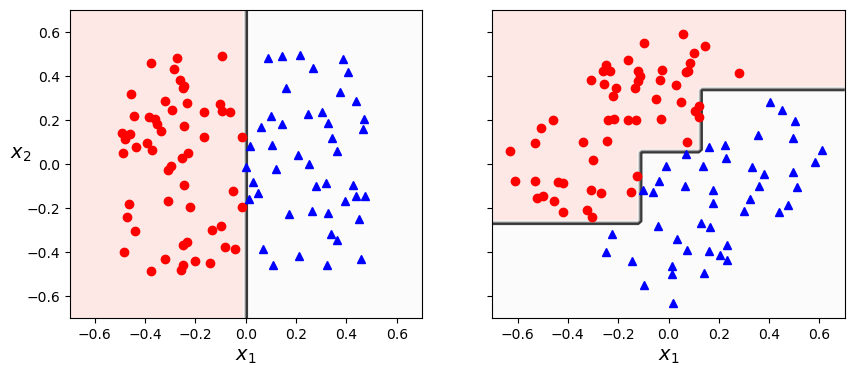

In [24]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)
    
np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")
plt.show()

An example with PCA applied to the iris data:

In [25]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

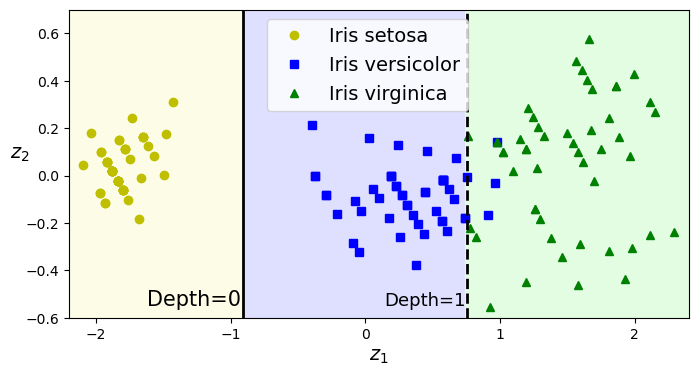

In [29]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=ListedColormap(['#fafab0', '#9898ff', '#a0faa0']))
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))
plt.show()

### Exercise 7:

In [39]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.2)

params = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': list(range(1, 7)),
    'min_samples_split': [2, 3, 4]
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(), params, cv=3)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=23)

In [40]:
y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8595

### Exercise 8:

In [ ]:
ShuffleSplit(n_splits = 1000)